In [ ]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *

In [ ]:

from torch.utils.data import Dataset, DataLoader


class custom_simple_dataset(Dataset):


    def __init__(self, data, window_size):

        self.data = data
        self.ws = window_size

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):

        inp = self.data[idx, :, :]
        label = self.data[idx, self.ws:, 1:]

        return inp, label


set = custom_simple_dataset(train_data, 4)

loader = DataLoader(set, batch_size=4, pin_memory=True)

for k, (x,y) in enumerate(loader):
    print(x.size(), y.size(), k)

In [ ]:
 #Define the LSTM model class

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

class LSTMmodel(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, layers, window_size=4):

        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ws = window_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, one_full_traj):

        seq = one_full_traj[:, 0:self.ws, :]
        lstm_out, hidden = self.lstm(seq)           
        pred = self.linear(lstm_out)
        out = one_full_traj[:, self.ws-1:self.ws, 1:] + pred[:, -1: , :]

        for t in range(1, self.ws):

            tmp = torch.cat(( one_full_traj[:,self.ws+t:self.ws+t+1, 0:1] , out[:, (t-1):t,:]), dim=2)
            seq = torch.cat((one_full_traj[:, t:self.ws+(t-1), :], tmp), dim=1)
            lstm_out, hidden = self.lstm(seq)           
            pred = self.linear(lstm_out)
            out = torch.cat((out, one_full_traj[:, self.ws+(t-1): self.ws+t, 1:] + pred[:, -1: , :]), dim=1)

        for t in range(self.ws, one_full_traj.size(dim=1) - self.ws):
            seq = torch.cat((out[:, t - self.ws : t , :], one_full_traj[:, t : t + self.ws, 0:1]), dim=2)
            
            lstm_out, hidden = self.lstm(seq)           
            pred = self.linear(lstm_out)

            out = torch.cat((out, out[:, t-1:t, :] + pred[:, -1: , :]), dim=1)

        return out, hidden          
  




In [ ]:
def test(test_data, model, steps=600, ws=10, plot_opt=False, n = 5, test_inits=1, rand=True, PSW_max = 0):
 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0
   
    if rand:
     np.random.seed(1234)
 
    ids = np.random.choice(test_inits, min([n, test_inits]), replace=False)
    ids = np.unique(ids)
 
 
    for i, x in enumerate(test_data):

        x=x.to(device)

        
        x = x.view(1,x.size(dim=0), x.size(dim=1))

        if i not in ids:
            continue
 
        with torch.inference_mode():
 
            pred = torch.zeros((steps, 3), device=device)
 
            if ws > 1:
                pred[0:ws, :] = x[0, 0:ws, :]
                pred[:, 0] = x[0, :, 0]
 
            else:
                pred[0, :] = x[0, 0, :]
                pred[:, 0] = x[0, :, 0]
 

            out, _ = model(x)
            pred[ws:,1:] = out
           
            test_loss += loss_fn(pred[ws:, 1], x[0, ws:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[ws:, 2], x[0, ws:, 2]).detach().cpu().numpy()
            total_loss += loss_fn(pred[ws:, 1:], x[0, ws:, 1:]).detach().cpu().numpy()

            #scale back:    
            if PSW_max != 0:
                pred[:,0] = pred[:,0]*PSW_max[0]
                pred[:,1] = pred[:,1]*PSW_max[1]
                pred[:,2] = pred[:,2]*PSW_max[2]
                x[0, :,0] = x[0, :,0]*PSW_max[0]
                x[0, :,1] = x[0, :,1]*PSW_max[1]
                x[0, :,2] = x[0, :,2]*PSW_max[2]

            if plot_opt:
                figure , axs = plt.subplots(1,3,figsize=(16,9))
           
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(x.detach().cpu().numpy()[0, :, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()
 
                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(x.detach().cpu().numpy()[0, :, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()
 
                axs[2].plot(x.detach().cpu().numpy()[0, :,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()
 
                plt.grid(True)
                plt.legend()
                plt.show()
           
    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)

In [ ]:
#with future:
 
def train(input_data, model, weight_decay, learning_rate=0.001, ws=0):
 
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
 
    model.train()
    total_loss = []
  
    for k, (x,y) in enumerate(input_data):  # inp = (u, x) label = x
        
        x = x.to(device)
        y = y.to(device)
        
        output, _ = model(x)
  
        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        
        # calculate the error
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
 
        total_loss.append(loss.detach().cpu().numpy())
 
   # return the average error of the next step prediction
    return np.mean(total_loss)

In [ ]:

params =                {
                           #"experiment_number" : 4,
                           "window_size" : 4,
                           "h_size" : 5,
                           "l_num" : 1,
                           "epochs" : 50,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.8,
                           "future_decay"  : 0.5,
                           "batch_size" : 10,
                           "future" : 10,
                           "cut_off_timesteps" : 950,
                           "drop_half_timesteps": False
                        }


# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"]).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data, PSW_max = get_data(path = "save_data_test4.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = params["drop_half_timesteps"],
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=params["part_of_data"])

print(input_data.size())

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*params["percentage_of_data"])
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-params["cut_off_timesteps"],:]
test_data = input_data[test_inits,:,:]

# dataloader for batching during training
train_set = custom_simple_dataset(train_data, window_size=params["window_size"])
train_loader = DataLoader(train_set, batch_size=params["batch_size"], pin_memory=True)

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(params["epochs"])):
    
    loss_epoch = train(train_loader, model, params["weight_decay"], learning_rate= params["learning_rate"], ws=params["window_size"])
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%20 == 0:

        _,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=params["window_size"], plot_opt=False, test_inits=len(train_inits), n = 20, PSW_max=PSW_max)

        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
                #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_train = test(test_data, model, steps=test_data.size(dim=1), ws=params["window_size"], plot_opt=False, test_inits=len(test_inits), n = 100, PSW_max=PSW_max)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

In [ ]:

#test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=True, n = 1, test_inits=len(test_data), rand=False)
test(input_data[train_inits,:,:], model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True, n = 1, test_inits=len(train_data), rand=False, PSW_max=0)

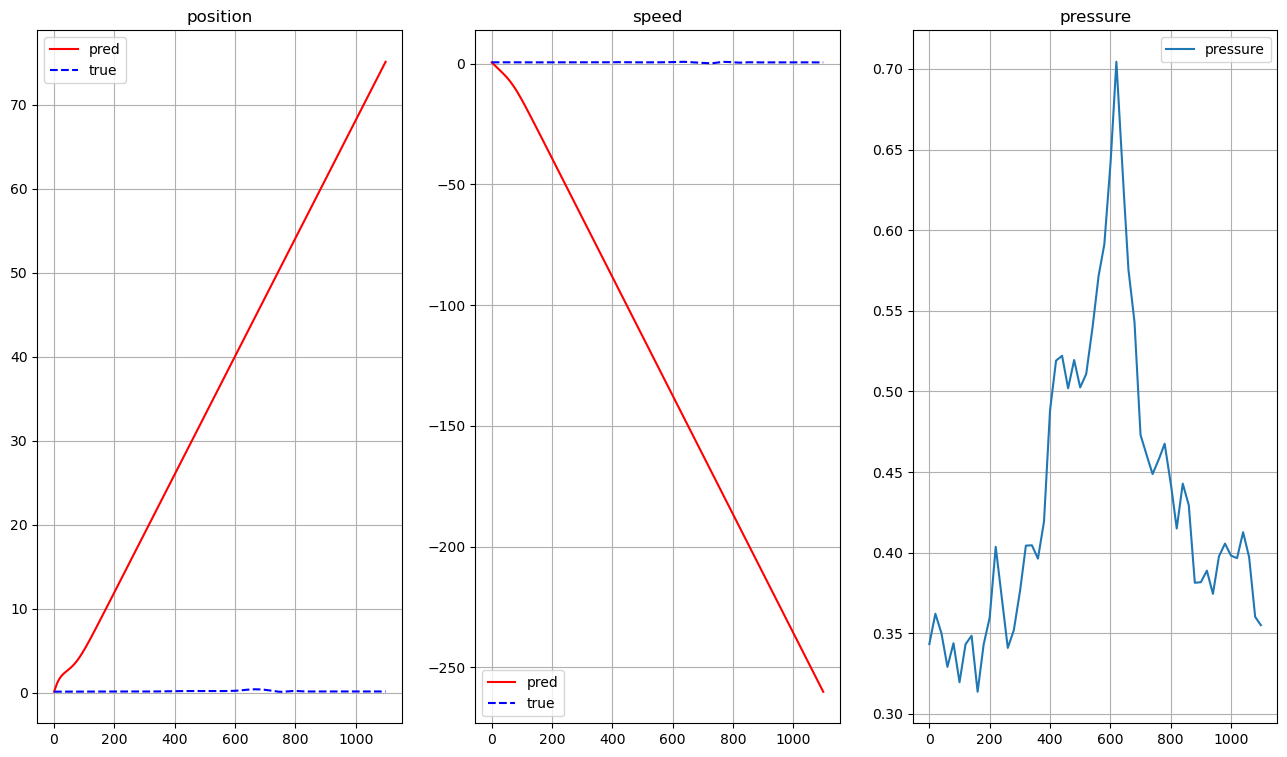

In [121]:
# Save the model
#path = f"Ventil_trained_NNs\lstm_ws0.pth"
#torch.save(model.state_dict(), path)

# Load the model and test it on the test data
path = "Ventil_trained_NNs\lstm_ws0.pth"


params =                                     {
                           "experiment_number" : 8,
                           "window_size" : 1,
                           "h_size" : 5,
                           "l_num" : 1,
                           "epochs" : 200,
                           "learning_rate" : 0.001,
                           "part_of_data" : 100, 
                           "weight_decay" : 1e-5,
                           "percentage_of_data" : 0.7,
                           "future_decay"  : 0.5,
                           "batch_size" : 30,
                           "future" : 10,
                           "cut_off_timesteps" : 700,
                           "drop_half_timesteps": False
                        }


# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=params["h_size"], out_size=2, layers=params["l_num"], window_size=params["window_size"]).to(device)

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]

#test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1, test_inits=len(test_data), rand=False, PSW_max=0)
test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=params["window_size"], plot_opt=True , n = 1,  test_inits=len(test_data), rand=False, PSW_max=0)


In [ ]:
  
        # def forward(self, one_full_traj):

        # seq = one_full_traj[0:self.ws, :]
        
        # lstm_out, hidden = self.lstm(seq)           
        # pred = self.linear(lstm_out)

        # out = one_full_traj[self.ws-1:self.ws, 1:] + pred[-1: , :]

        # #print("Initial Value:", seq)

        # for i, t in enumerate(range(1, self.ws)):
        #     tmp = torch.cat(( one_full_traj[self.ws+t:self.ws+t+1, 0:1] , out[(t-1):t,:]), dim=1)
            
        #     seq = torch.cat((one_full_traj[t:self.ws+(t-1), :], tmp), dim=0)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)
        #     out = torch.cat((out, one_full_traj[self.ws+(t-1): self.ws+t, 1:] + pred[-1: , :]))

        #    # print("Window size many outputs",  out, i )

        # for k,t in enumerate( range(self.ws, one_full_traj.size(dim=0) - self.ws)):
        #     seq = torch.cat((out[t - self.ws : t , :], one_full_traj[t : t + self.ws, 0:1]), dim=1)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)

        #     out = torch.cat((out, out[t-1:t, :] + pred[-1: , :]))


        #    # print("Rest of trajectory using", out, k)

        # return out, hidden        
    

        #works
        #Without Resnet connection at the end
        
    #    def forward(self, one_full_traj):

        # seq = one_full_traj[0:self.ws, :]
        
        # lstm_out, hidden = self.lstm(seq)           
        # pred = self.linear(lstm_out)

        # out = pred[-1: , :]

        # for t in range(1, self.ws):
        #     tmp = torch.cat(( one_full_traj[self.ws+t:self.ws+t+1, 0:1] , out[(t-1):t,:]), dim=1)
            
        #     seq = torch.cat((one_full_traj[t:self.ws+(t-1), :], tmp), dim=0)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)
        #     out = torch.cat((out, pred[-1:,:]))

        # for t in range(self.ws, one_full_traj.size(dim=0) - self.ws):

        #     seq = torch.cat((out[t - self.ws : t , :], one_full_traj[t : t + self.ws, 0:1]), dim=1)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)
        #     out = torch.cat((out, pred[-1:,:]))

        # return out, hidden          
